# Мананников Н.Д.

## Импорт библиотек для работы бота с API Вконтакте

In [1]:
import vk_api
import random
import requests
from datetime import datetime
from vk_api.longpoll import VkLongPoll, VkEventType
from vk_api.keyboard import VkKeyboard, VkKeyboardColor

## Импорт библиотек для визуализации Облака Слова

In [2]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud

## Импорт библиотек для процесса обучения модели и классификации

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from pymorphy2 import MorphAnalyzer
from sklearn.tree import export_graphviz

import glob
import re
import warnings
import pandas

warnings.simplefilter(action='ignore', category=FutureWarning)

## Объявление переменных необходимх для работы с API

In [4]:
vk_session = vk_api.VkApi(token='12153e7f74d0c0257192e7f5b525f894cfd507168976a15b0d3490235ff76bd85b2a6fa05b42f9cd6737b')

longPoll = VkLongPoll(vk_session)
vk = vk_session.get_api()

## Объявление переменных для классификатора

In [5]:
classes_list = []
proccesed_texts = []
texts = []
results = [0,0,0]
m = MorphAnalyzer()
regex = re.compile("[А-Яа-я]+")

### Корпус стоп-слов

In [6]:
stopwords = ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так',
              'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 
              'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 
              'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж',
              'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 
              'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего',
              'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого',
              'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас',
              'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть',
              'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много',
              'разве', 'три', 'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда', 'лучше', 
              'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между']

## Создание классов для работы с текстами

In [7]:
class Text:
    
    text = ''
    journal = ''
    
    def __init__(self, text, journal):
        self.text = text
        self.journal = journal

In [8]:
class Text_proccesor:
    
    proccesed_text = ''
    
    def tokenize(text, regex=regex):
        proccesed_text = " ".join(regex.findall(text))
        proccesed_text = proccesed_text.lower()
        return(proccesed_text)

    
    def lemmatize(text):
        proccesed_text = [m.parse(word)[0].normal_form for word in text.split()]
        return(proccesed_text)
    
    def stopwords_remove(text):
        proccesed_text = ' '.join([token for token in text.split() if not token in stopwords])
        return(proccesed_text) 

### Функция создания интерфейса клавиатуры для бота ВКонтакте

In [9]:
def create_keyboard(response):
    if response == 'начать':
        keyboard = VkKeyboard(one_time=False)

        keyboard.add_button('Отправить статью', color=VkKeyboardColor.POSITIVE)
        keyboard.add_line()
        keyboard.add_button('Список команд', color=VkKeyboardColor.DEFAULT)
        keyboard.add_button('Инфо', color=VkKeyboardColor.DEFAULT)

        keyboard = keyboard.get_keyboard()
        return keyboard

### Функция для генерации Облака Слов

In [10]:
def wordcloud_gen(text):
    #mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
    mpl.rcParams['font.size']=120                #10 
    mpl.rcParams['savefig.dpi']=1000             #72 
    mpl.rcParams['figure.subplot.bottom']=.1 


    data = text

    wordcloud = WordCloud(
                              background_color='white',
                              max_words=40,
                              max_font_size=40, 
                              random_state=42
                             ).generate(str(data))

    print(wordcloud)
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    fig.savefig("word1.png", dpi=900)

## Обучение модели

### Получение обучающего корпуса из файлов.

In [11]:
#Указываем директорию и получаем список всех ее файлов
all_files = glob.glob('D:/Repo/Diploma/Data/Test/*.txt')

#Проходимся по списку путей, открываем каждый файл для чтения
for file in all_files:
    opened_file = open(file,'r')
    journal = next(opened_file)
    text = opened_file.read()
    #Для каждого открытого файла инициализируем объект класса Text, в переменную text кладем 
    #текст документа, а в переменную category - ЗАГЛУШКУ
    classes_list.append(Text(text,journal))

### Очистка обучающих данных

In [12]:
for text in classes_list:
    tokenized_text = Text_proccesor.tokenize(text.text)
    no_stopwords = Text_proccesor.stopwords_remove(tokenized_text)
    proccesed_texts.append(' '.join(Text_proccesor.lemmatize(no_stopwords)))

### Непосредственное обучение модели

In [13]:
#Переносим тексты из объектов класса Text в список для классификации
texts_labels = []

for i in proccesed_texts:
    texts.append(i)
    
for i in classes_list:
    texts_labels.append(i.journal)



for i in range(100):

    text_clf = Pipeline([
        ('tfidf',TfidfVectorizer()),
        ('clf', RandomForestClassifier(n_estimators=10))
    ])
    
    
    text_clf.fit(texts, texts_labels)



## Запуск прослушивания longpoll`a для общения с пользователем

Message sent: 23:23:40
{}
отправить статью
Message sent: 23:23:43
{'attach1_type': 'doc', 'attach1': '163458875_539374878'}



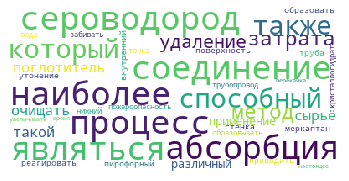

['Спорт\n']
Message sent: 23:24:58
{'attach1_type': 'doc', 'attach1': '163458875_539375041'}



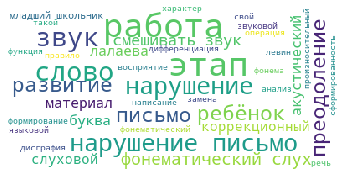

['Format: Педагогика\n']
Message sent: 23:30:23
{'attach1_type': 'doc', 'attach1': '163458875_539375682'}



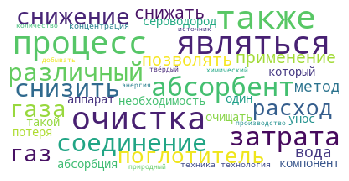

['Format.Техника и технологии\n']


KeyboardInterrupt: 

In [14]:
for event in longPoll.listen():

    if event.type == VkEventType.MESSAGE_NEW and event.to_me:
        print('Message sent: ' + str(datetime.strftime(datetime.now(), "%H:%M:%S")))
        response = event.text.lower()
        keyboard = create_keyboard(response)
        doc = event.attachments
        print(doc)
        print(response)

        if doc != {}:
            doc_info = vk_session.method(
                'messages.getById',
                {
                    'message_ids': event.message_id,
                }

            )
            try:
                url = doc_info['items'][0]['attachments'][0]['doc']['url']
                download = requests.get(url)
                target = download.text.encode('latin1').decode('cp1251')
                tokenized_target = Text_proccesor.tokenize(target)
                no_stopwords_target = Text_proccesor.stopwords_remove(tokenized_target)
                proccesed_target =(' '.join(Text_proccesor.lemmatize(no_stopwords_target)))
                result = text_clf.predict([proccesed_target])
                wordcloud_gen(proccesed_target)
                print (result)
                vk_session.method(
                'messages.send',
                {
                    'user_id': event.user_id,
                    'message': result,
                    'random_id': random.randint(1, 2800000),
                    'keyboard': keyboard
                }
            )
                
            except:
                print('error')
                vk_session.method(
                'messages.send',
                {
                    'user_id': event.user_id,
                    'message': 'Произошла ошибка при обработке статьи, проверьте загружаемый документ в соответсвии с требованиями системы',
                    'random_id': random.randint(1, 2800000),
                    'keyboard': keyboard
                }
            )


        elif response == 'начать':
            vk_session.method(
                'messages.send',
                {
                    'user_id': event.user_id,
                    'message': 'Вас приветствует автоматическая рекомендательная система МАН, чтобы получить подробную инструкцию нажмите кнопку «Инфо» на клавиатуре',
                    'random_id': random.randint(1, 2800000),
                    'keyboard': keyboard
                }
            )

        elif response == 'отправить статью':
            vk_session.method(
                'messages.send',
                {
                    'user_id': event.user_id,
                    'message': 'Чтобы получить корректный результат - необходимо поместить основной текст статьи в файл формата .txt и отправить в данный диалог, как вложение.',
                    'random_id': random.randint(1, 2800000),
                }
            )
            
        elif response == 'инфо':
            vk_session.method(
                'messages.send',
                {
                'user_id': event.user_id,
                'message': 'Данное программное обеспечение позволяет получить реккомендацию по размещению статьи в том или ином журнале',
                'random_id': random.randint(1, 2800000),  
            }
        )

        else:
            vk_session.method(
                'messages.send',
                {
                    'user_id': event.user_id,
                    'message': 'Пожалуйста, воспользуйтесь клавиатурой для взаимодействия с ботом, если по какой-то причине клавиатура не отобразилась напишите собщение с текстом «Начать»',
                    'random_id': random.randint(1, 2800000)
                }
            )
